In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings

In [3]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

In [4]:
design.variables['cpw_width'] = '15 um'
design.variables['cpw_gap'] = '9 um'

In [5]:
# Allow running the same cell here multiple times to overwrite changes
design.overwrite_enabled = True

## Custom options for all the transmons
options = dict(
    # Some options we want to modify from the defaults
    # (see below for defaults)
    pad_width = '425 um',
    pocket_height = '650um',
    # Adding 4 connectors (see below for defaults)
    connection_pads=dict(
        readout = dict(loc_W=+1,loc_H=-1, pad_width='200um'),
        bus1 = dict(loc_W=-1,loc_H=+1, pad_height='30um'),
        bus2 = dict(loc_W=-1,loc_H=-1, pad_height='50um')
    )
)

## Create 4 transmons

q1 = TransmonPocket(design, 'Q1', options = dict(
    pos_x='+2.42251mm', pos_y='+0.0mm', **options))
q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x='+0.0mm', pos_y='-0.95mm', orientation = '270', **options))
q3 = TransmonPocket(design, 'Q3', options = dict(
    pos_x='-2.42251mm', pos_y='+0.0mm', orientation = '180', **options))
q4 = TransmonPocket(design, 'Q4', options = dict(
    pos_x='+0.0mm', pos_y='+0.95mm', orientation = '90', **options))

RouteMeander.get_template_options(design)

options = Dict(
        lead=Dict(
            start_straight='0.2mm',
            end_straight='0.2mm'),
        trace_gap='9um',
        trace_width='15um')

def connect(component_name: str, component1: str, pin1: str, component2: str, pin2: str,
            length: str, asymmetry='0 um', flip=False, fillet='90um'):
    """Connect two pins with a CPW."""
    myoptions = Dict(
        fillet=fillet,
        hfss_wire_bonds = True,
        pin_inputs=Dict(
            start_pin=Dict(
                component=component1,
                pin=pin1),
            end_pin=Dict(
                component=component2,
                pin=pin2)),
        total_length=length)
    myoptions.update(options)
    myoptions.meander.asymmetry = asymmetry
    myoptions.meander.lead_direction_inverted = 'true' if flip else 'false'
    return RouteMeander(design, component_name, myoptions)

asym = 140
cpw1 = connect('cpw1', 'Q1', 'bus2', 'Q2', 'bus1', '6.0 mm', f'+{asym}um')
cpw2 = connect('cpw2', 'Q3', 'bus1', 'Q2', 'bus2', '6.1 mm', f'-{asym}um', flip=True)
cpw3 = connect('cpw3', 'Q3', 'bus2', 'Q4', 'bus1', '6.0 mm', f'+{asym}um')
cpw4 = connect('cpw4', 'Q1', 'bus1', 'Q4', 'bus2', '6.1 mm', f'-{asym}um', flip=True)

gui.rebuild()
gui.autoscale()

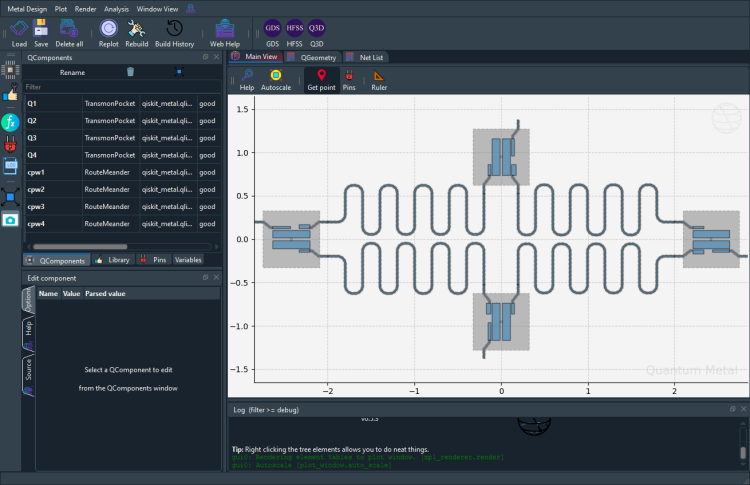

In [6]:
gui.screenshot()

In [7]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

In [8]:
c1.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 15,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': True,
 'solution_order': 'High',
 'solver_type': 'Iterative'}

In [9]:
# example: update single setting
c1.sim.setup.max_passes = 6
# example: update multiple settings
c1.sim.setup_update(solution_order = 'Medium', auto_increase_solution_order = 'False')

c1.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 6,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': 'False',
 'solution_order': 'Medium',
 'solver_type': 'Iterative'}

In [10]:
c1.sim.run(components=['Q1'], open_terminations=[('Q1', 'readout'), ('Q1', 'bus1'), ('Q1', 'bus2')])

INFO 05:05PM [connect_project]: Connecting to Ansys Desktop API...
INFO 05:05PM [load_ansys_project]: 	Opened Ansys App
INFO 05:05PM [load_ansys_project]: 	Opened Ansys Desktop v2025.1.0
INFO 05:05PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/shumail-a/Documents/Ansoft/
	Project:   Project1
INFO 05:05PM [connect_design]: No active design found (or error getting active design).
INFO 05:05PM [connect]: 	 Connected to project "Project1". No design detected
INFO 05:05PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
WARNING 05:05PM [connect_setup]: 	No design setup detected.
WARNING 05:05PM [connect_setup]: 	Creating Q3D default setup.
INFO 05:05PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:05PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:05PM [analyze]: Analyzing setup Setup


com_error: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024349), None)

In [11]:
c1.sim.capacitance_matrix

{}

In [12]:
c1.stop()

AttributeError: 'LOManalysis' object has no attribute 'stop'